# Моделирование систем массового обслуживания

Простейшая СМО без очереди с равномерной взаимопомощью между каналами. Имеется простейшая n-канальная СМО с отказами, на которую поступает поток заявок с интенсивностью X. Между каналами осуществляется взаимопомощь, но не объединением всех каналов в один, как в предыдущем примере, а так называемая «равномерная» организованная следующим образом. Если заявка приходит в момент, когда все п каналов свободны, то все каналы принимаются за ее обслуживание; если в момент обслуживания заявки приходит еще одна, часть каналов переключается на ее обслуживание; если, пока обслуживаются эти две заявки, приходит еще заявка, часть каналов переключается на ее обслуживание и т.д., пока не окажутся занятыми все п каналов; если они все заняты, вновь пришедшая заявка получает отказ. Функция  ф(k) = k\Y  т.е. обслуживание к каналами в к раз быстрее обслуживания одним каналом. Составить размеченный граф состояний СМО, определить финальные вероятности состояний и характеристики эффективности. Сравнить с характеристиками эффективности для системы без взаимопомощи.

Граф состояний СМО:

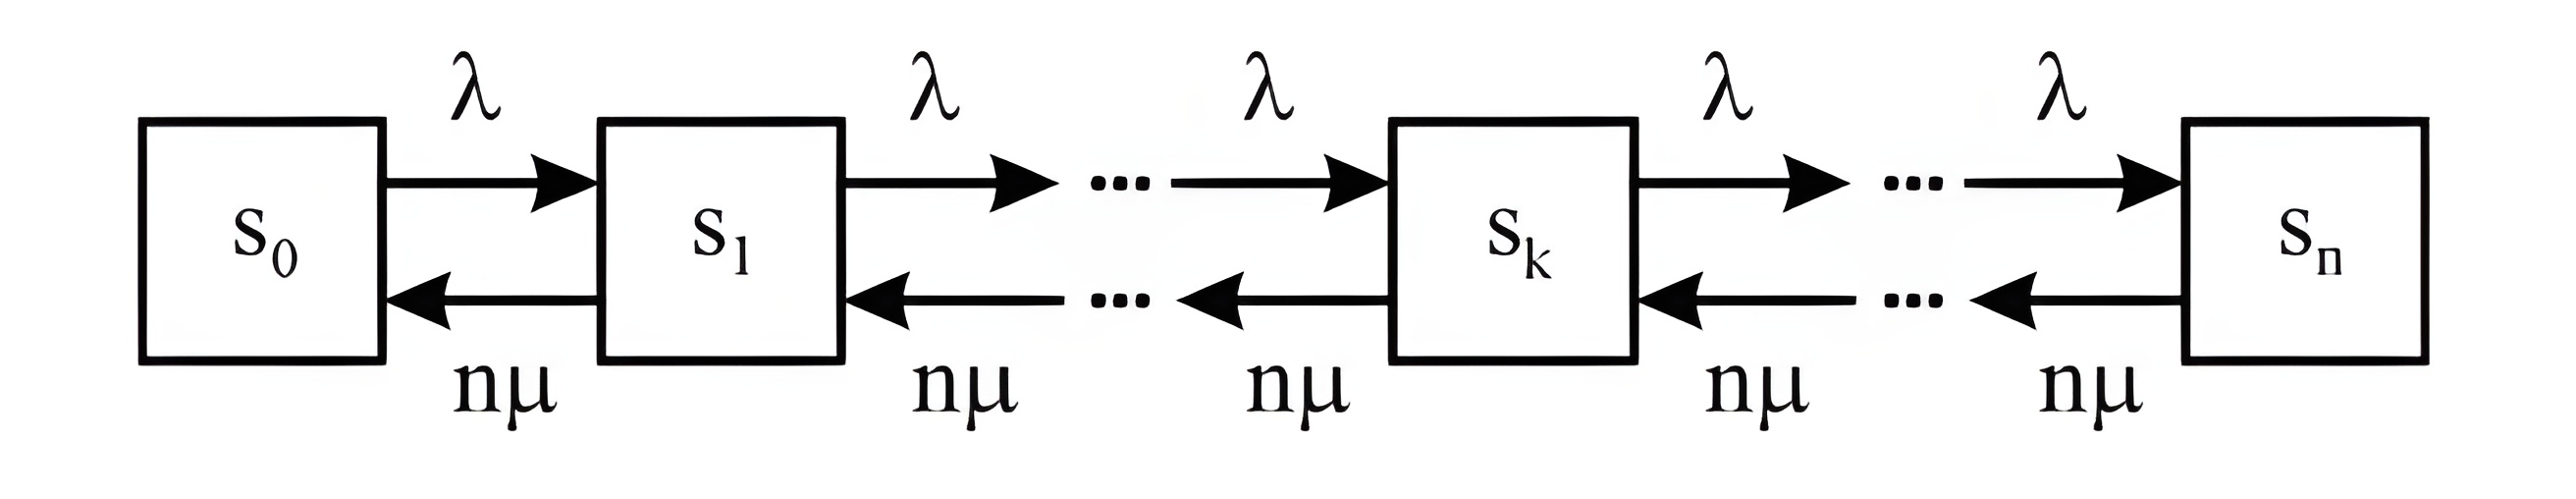

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import queue
from collections import deque
from IPython.display import display, HTML

In [41]:
def theor_efficency_params_usual(l, mu, ch_amount):
        ro = l / mu
        p_0 = 1
        for i in range(1, ch_amount + 1):
            p_0 += ro ** i  / math.factorial(i)
        p_0 = 1 / p_0
        p_list = [p_0]
        for i in range(1, ch_amount + 1):
            p_list.append( p_0 * ro ** i  / math.factorial(i))
        
        p_rej = p_list[-1]
        
        Q = 1 - p_rej
        
        A = Q * l
        
        ch_busy = Q * ro
        
        return p_list, A, Q, p_rej, ch_busy

In [26]:
theor_efficency_params_usual(1, 0.5, 4)

([0.14285714285714285,
  0.2857142857142857,
  0.2857142857142857,
  0.19047619047619047,
  0.09523809523809523],
 0.9047619047619048,
 0.9047619047619048,
 0.09523809523809523,
 1.8095238095238095)

In [4]:
def state_probabilities_help(l :float, mu :float, ch_amount: int):
    ro = l / (mu * ch_amount)
    p_0 = 0
    p_list = []
    for i in range(ch_amount + 1):
        p_0 += ro**i
    p_0 = 1 / p_0
    for i in range(ch_amount + 1):
        p_list.append (p_0 * ro**i)
        
    return p_list

In [39]:
def theor_efficency_params_help(l :float, mu :float, ch_amount: int):
    ro = l / (mu * ch_amount) 
    
    p_list = state_probabilities_help(l, mu, ch_amount)
    
    p_rej = p_list[-1]
    
    Q = 1 - p_rej
        
    A = Q * l
    
    av_busy_ch_num = 1 - p_list[0]
    
    p_q = 1 - p_list[0]
    
    ch_busy = Q * ch_amount
    
    return p_list, A, Q, p_rej, ch_busy, p_q, av_busy_ch_num



In [40]:
theor_efficency_params_help(3, 3, 3)

([0.675, 0.225, 0.075, 0.024999999999999994],
 2.925,
 0.975,
 0.024999999999999994,
 2.925,
 0.32499999999999996,
 0.32499999999999996)

In [7]:
def get_sample_exp(l : float):
    return np.random.exponential(1 / l)

In [42]:

class QueueingSystem:
    
    def __init__(self, l, mu, ch_number, sample_size = 10000):
        self.processed = []
        self.rejected = []
        self.time = 0.0
        self.q = queue.Queue(ch_number)
        self.l = l
        self.channels = ch_number
        self.mu = mu * ch_number
        self.sample_size = sample_size
        self.generated = 0
        self.state_probs = [0] * (ch_number + 1)
    
    
    def simulate(self):
        req_c = 0.0
        proc_c = 0.0
        step = 0.00001
        req_delay = 0.0
        proc_delay = get_sample_exp(self.mu) / 1000
        
        while (self.generated <= self.sample_size):
            if (req_c >= req_delay):
                self.generate_request()
                req_delay = get_sample_exp(self.l) / 1000
                req_c = 0.0
                self.generated += 1
            self.state_probs[self.q.qsize()] += 1
            if not self.q.empty():
                if (proc_c >= proc_delay):
                    self.process_request()
                    proc_delay = get_sample_exp(self.mu) / 1000
                    proc_c = 0.0
                proc_c += step
            self.state_probs[self.q.qsize()] += 1
            
            req_c += step
            self.time += step
            
        return self.analyze_emp_data()
    
        
    def analyze_emp_data(self):
        #print(self.sample_size, len(self.processed), self.sample_size - len(self.processed))
        
        p_list = []
        s = sum(self.state_probs)
        [p_list.append(i / s) for i in self.state_probs]
        
        p_rej = p_list[-1]
    
        Q = 1 - p_rej
        
        A = Q * self.l
        
        ch_busy = Q * self.channels
        
        
        return p_list, A, Q, p_rej, ch_busy
    

    def generate_request(self):
        if not self.q.full():
            self.q.put(self.time)
        else:
            self.rejected.append(self.time)


    def process_request(self):
        self.processed.append((self.q.get(), self.time))


In [43]:
sim = QueueingSystem(1, 0.5, 4, 10000)
data = sim.simulate()
print(data)

([0.5156943443368925, 0.25785727878586495, 0.12929765418014627, 0.06464192500988476, 0.03250879768721153], 0.9674912023127885, 0.9674912023127885, 0.03250879768721153, 3.869964809251154)


In [44]:
print(theor_efficency_params_help(1, 0.5, 4))

([0.5161290322580645, 0.25806451612903225, 0.12903225806451613, 0.06451612903225806, 0.03225806451612903], 0.967741935483871, 0.967741935483871, 0.03225806451612903, 3.870967741935484, 0.4838709677419355, 0.4838709677419355)


In [66]:
def compare_features(l :float, mu :float, ch_amount: int):
    sim = QueueingSystem(l, mu, ch_amount, 10000)
    emp = sim.simulate()
    theor = theor_efficency_params_help(l, mu, ch_amount)
    data1 = {'Теоретические вероятности состояний': theor[0], 
            'Эмпирические вероятности состояний': emp[0]}
    df1 = pd.DataFrame(data1)
    print("λ = " + str(l), ", μ = " + str(mu), ", channels: " + str(ch_amount))
    display(df1)
    clr1 = [(0.3,0.7,0.3), (0.25, 0.45, 0.85)]
    df1.plot(kind='bar', color=clr1).legend(loc='best')
    data2 = {'Теоретические характеристики': theor[1:4], 
            'Эмпирические характеристики': emp[1:4]}
    headers = ['A', 'Q', 'Reject P']
    df2 = pd.DataFrame(data2, index=headers)
    
    clr2 = [(1, 0.8, 0), (1, 0.35, 0.1)]
    df2.plot(kind='bar', color=clr2).legend(loc='best')
    display(df2)

In [67]:
def compare_usual_helped(l :float, mu :float, ch_amount: int):
    sim = QueueingSystem(l, mu, ch_amount, 10000)
    emp = sim.simulate()
    helps = theor_efficency_params_help(l, mu, ch_amount)
    usual = theor_efficency_params_usual(l, mu, ch_amount)
    data2 = {'Обычная многокан. СМО': usual[1:4], 
            'Со взаимопомощью': helps[1:4]}
    headers = ['A', 'Q', 'Reject P']
    df2 = pd.DataFrame(data2, index=headers)
    
    clr2 = [(0.3,0.7,0.3), (0.25, 0.45, 0.85)]
    df2.plot(kind='bar', color=clr2).legend(loc='best')
    display(df2)

,Обычная многокан. СМО,Со взаимопомощью
A,7.611524,8.581034
Q,0.362454,0.408621
Reject P,0.637546,0.591379


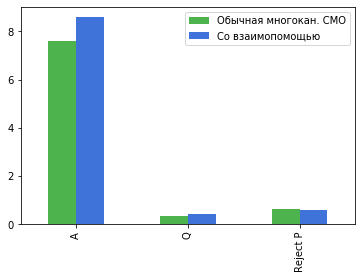

In [70]:
compare_usual_helped(21, 3, 3)

λ = 3 , μ = 3 , channels: 3


,Теоретические вероятности состояний,Эмпирические вероятности состояний
0,0.675,0.671866
1,0.225,0.230940
2,0.075,0.074668
3,0.025,0.022526


,Теоретические характеристики,Эмпирические характеристики
A,2.925,2.932422
Q,0.975,0.977474
Reject P,0.025,0.022526


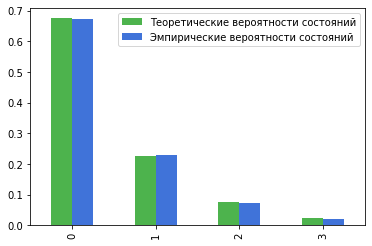

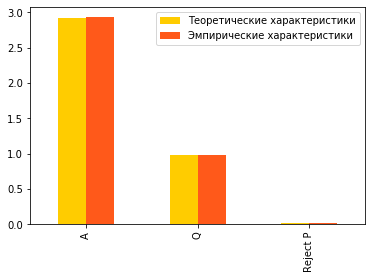

In [69]:
compare_features(3, 3, 3)

λ = 1 , μ = 0.5 , channels: 4


,Теоретические вероятности состояний,Эмпирические вероятности состояний
0,0.516129,0.526446
1,0.258065,0.252902
2,0.129032,0.126501
3,0.064516,0.063343
4,0.032258,0.030807


,Теоретические характеристики,Эмпирические характеристики
A,0.967742,0.969193
Q,0.967742,0.969193
Reject P,0.032258,0.030807
avg. busy ch-ls,3.870968,3.876770


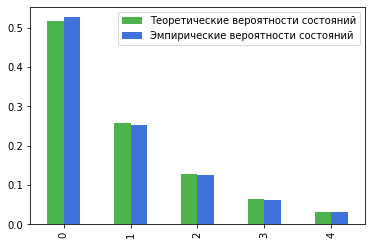

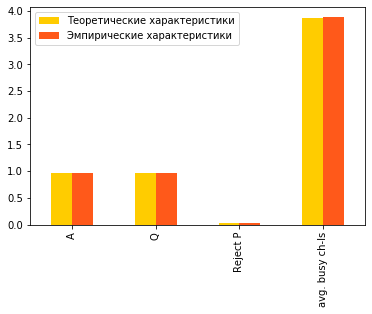

In [54]:
compare_features(1, 0.5, 4)

λ = 1 , μ = 0.25 , channels: 4


,Теоретические вероятности состояний,Эмпирические вероятности состояний
0,0.2,0.213060
1,0.2,0.203880
2,0.2,0.194799
3,0.2,0.197233
4,0.2,0.191027


,Теоретические характеристики,Эмпирические характеристики
A,0.8,0.808973
Q,0.8,0.808973
Reject P,0.2,0.191027
avg. busy ch-ls,3.2,3.235892


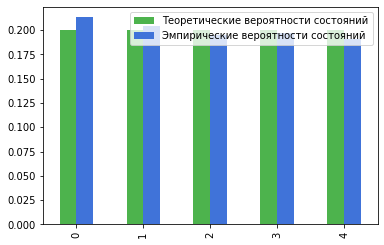

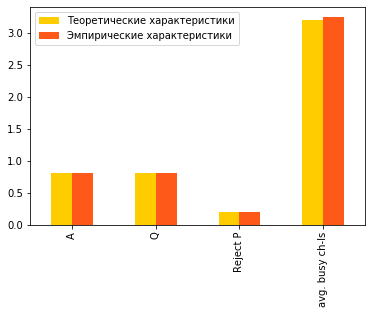

In [57]:
compare_features(1, 0.25, 4)

λ = 5 , μ = 1 , channels: 3


,Теоретические вероятности состояний,Эмпирические вероятности состояний
0,0.099265,0.090137
1,0.165441,0.166430
2,0.275735,0.277793
3,0.459559,0.465641


,Теоретические характеристики,Эмпирические характеристики
A,2.702206,2.671796
Q,0.540441,0.534359
Reject P,0.459559,0.465641
avg. busy ch-ls,1.621324,1.603078


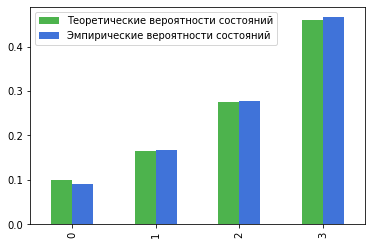

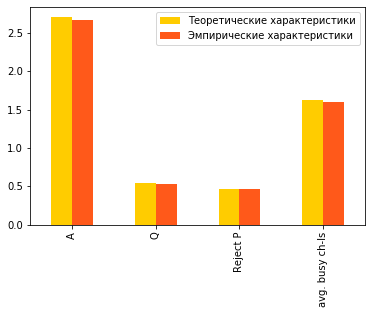

In [58]:
compare_features(5, 1, 3)

λ = 1 , μ = 2 , channels: 4


,Теоретические вероятности состояний,Эмпирические вероятности состояний
0,0.875027,0.876488
1,0.109378,0.108738
2,0.013672,0.013047
3,0.001709,0.001513
4,0.000214,0.000213


,Теоретические характеристики,Эмпирические характеристики
A,0.999786,0.999787
Q,0.999786,0.999787
Reject P,0.000214,0.000213


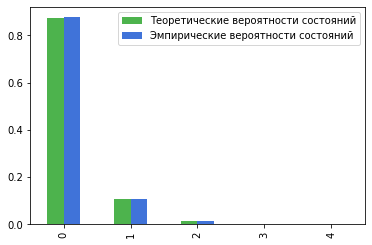

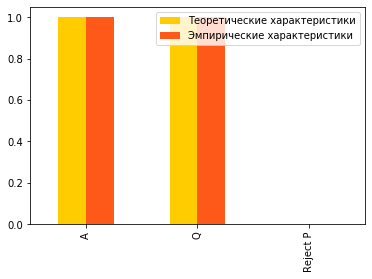

In [72]:
l = 1
mu = 2
ch_amount = 4

compare_features(l, mu, ch_amount)